Comtrade API
- Собрать для топ 50 стран экспортеров нефти (2709) в 2019 году, собрать для них статистику эксорта и зеркального экспорта (в 2023 году)

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
country_dict = requests.get('https://comtradeapi.un.org/files/v1/app/reference/Reporters.json').json()['results'] # Сделали запрос

In [3]:
country = (pd.DataFrame([(i['id'],i['text']) for i in country_dict])
 .rename({0:'id',1:'country'},axis=1)) # Преобразовали в датафрейм

In [4]:
country.head(5)

,id,country
0,4,Afghanistan
1,8,Albania
2,12,Algeria
3,20,Andorra
4,24,Angola


# Экспорт нефти 2019

Шаблон: https://comtradeapi.un.org/data/v1/get/{typeCode}/{freqCode}/{clCode}

In [5]:
typeCode = 'C'
freqCode = 'A'
clCode = 'HS'

links = f'https://comtradeapi.un.org/data/v1/get/{typeCode}/{freqCode}/{clCode}' #Базовая конструкция для нашей ссылки

In [6]:
def params(period:int,partnerCode:int,flowCode:str,cmdCode):
    parametrs = {
              'subscription-key':'48b718d2cfe449d58f27d7d2e9faab5d',
              'period': period,
               'partnerCode':partnerCode,
               'flowCode':flowCode,
               'cmdCode':cmdCode,
               'motCode':0,
               'partner2Code':0,
               'customsCode':'C00'
    }
    return parametrs

In [7]:
parametrs = params(2019,0,'X',270900)

In [8]:
request_2019 = requests.get(links,params=parametrs).json()
request_2019 = request_2019['data']
time.sleep(10)
#Запрос

In [9]:
export = pd.DataFrame({
    'reporterCode':[i['reporterCode'] for i in request_2019],
    'primaryValue':[i['primaryValue'] for i in request_2019],
    'netWgt':[i['netWgt'] for i in request_2019]
})
#Преобразование в датафрейм

In [10]:
pd.options.display.float_format ='{:,.3f}'.format #Для приятного отображения

In [11]:
print(f'Размеры: {export.shape}')
export.head(5)

Размеры: (101, 3)


,reporterCode,primaryValue,netWgt
0,24,"31,534,121,190.558","76,402,028,259.000"
1,31,"14,814,132,708.690","30,837,085,666.000"
2,32,"1,119,911,767.130","2,615,804,000.000"
3,36,"6,566,389,781.634",NaN
4,52,"15,100,491.000","37,600,160.000"


In [12]:
export.dropna(inplace=True)

export_unique = (export
 .merge(country,how='left',left_on = 'reporterCode',right_on = 'id')
 .drop(['reporterCode'],axis = 1)
 .sort_values(by = 'netWgt',ascending=False))


print(f'Раземеры {export_unique.shape}')
export_unique.head(5)

Раземеры (87, 4)


,primaryValue,netWgt,id,country
79,"127,284,293,029.930","271,730,227,836.430",784,United Arab Emirates
66,"122,228,578,653.300","269,175,244,771.000",643,Russian Federation
14,"68,100,946,475.118","145,386,082,443.058",124,Canada
85,"65,323,191,031.000","139,455,959,545.975",842,USA
0,"31,534,121,190.558","76,402,028,259.000",24,Angola


In [13]:
export_unique['id'] = export_unique['id'].astype(int)

In [14]:
index = list(export_unique.sort_values(by = 'netWgt',ascending=False).head(50)['id'])
index[:4]

[784, 643, 124, 842]

Ну вроде похоже на правду 

# Экспорт 2023

In [15]:
parametrs_2023 = params(2023,0,'X','TOTAL')

In [16]:
request_2023_exp = requests.get(links,params= parametrs_2023).json()
request_2023_exp = request_2023_exp['data']
time.sleep(10)

In [17]:
export_2023 = pd.DataFrame({
    'reporterCode':[i['reporterCode'] for i in request_2023_exp],
    'primaryValue':[i['primaryValue'] for i in request_2023_exp]
})
export_2023.head(5)

,reporterCode,primaryValue
0,20,"252,365,105.054"
1,28,"30,496,874.225"
2,31,"33,898,554,855.280"
3,32,"66,788,515,986.350"
4,36,"369,235,124,159.052"


In [18]:
export_unique_2023 = export_2023[export_2023['reporterCode'].isin(index)]
print(f'Размеры {export_unique_2023.shape}')
export_unique_2023.head(5)

Размеры (31, 2)


,reporterCode,primaryValue
2,31,"33,898,554,855.280"
3,32,"66,788,515,986.350"
8,52,"475,842,549.000"
14,84,"253,373,381.831"
15,96,"11,240,624,705.271"


In [19]:
export_val_2023 = (export_unique_2023
              .merge(country,how ='left',left_on = 'reporterCode',right_on='id')
              .drop(['id'],axis = 1))
export_val_2023['export_cherez_drug_stran'] = 0.0
export_val_2023.head(5)

,reporterCode,primaryValue,country,export_cherez_drug_stran
0,31,"33,898,554,855.280",Azerbaijan,0.000
1,32,"66,788,515,986.350",Argentina,0.000
2,52,"475,842,549.000",Barbados,0.000
3,84,"253,373,381.831",Belize,0.000
4,96,"11,240,624,705.271",Brunei Darussalam,0.000


Это точно правильные данные, проверил на этом сайте:https://trendeconomy.ru/

In [20]:
export_val_index = export_val_2023['reporterCode']

Есть проблема в том, что в 2023 нет данных экспорта 19 стран из нашего топа.

Проверим это на Саудовской Аравии

In [21]:
export_2023[export_2023['reporterCode'] == 784]

,reporterCode,primaryValue


Оставлю все как есть

# Запросы для зеркального экспорта

In [22]:
def get(links,params, index):
    request = requests.get(links,params = params)
    if request.ok:
        print(f'Информация предоставлена для id: {index}')
        return request
    else:
        print('Ошибка')

In [23]:
def get_data(request):
    country_imp = request.json()['data']
    country_import =pd.DataFrame({
    'reporterCode':[i['reporterCode'] for i in country_imp],
    'partnerCode':[i['partnerCode'] for i in country_imp],
    'primaryValue':[i['primaryValue'] for i in country_imp]
    })
    return country_import
    

In [24]:
def preprocessing_data(country_import,export_val_2023,index):
    country_import.drop_duplicates(subset = 'reporterCode',inplace=True)
    if (country_import['reporterCode'] == index).sum() !=0:
        summary =country_import.primaryValue.sum()- country_import[country_import['reporterCode'] == index].primaryValue.iloc[0]
    else:
        summary =country_import.primaryValue.sum()
    export_val_2023.loc[export_val_2023.reporterCode == index,'export_cherez_drug_stran'] = summary  
    return export_val_2023

In [25]:
for index in export_val_index:
    ################################## ЗАПРОС
    parametrs_zer = params(2023,index,'M','TOTAL')
    
    request = get(links,parametrs_zer,index)
    
    ################################ Выгрузка
    country_import =get_data(request) 
    
    ################################# Обработка
    export_val_2023 = preprocessing_data(country_import=country_import,export_val_2023 = export_val_2023,index =index)
    
    time.sleep(10)
    
    

Информация предоставлена для id: 31
Информация предоставлена для id: 32
Информация предоставлена для id: 52
Информация предоставлена для id: 84
Информация предоставлена для id: 96
Информация предоставлена для id: 104
Информация предоставлена для id: 124
Информация предоставлена для id: 156
Информация предоставлена для id: 170
Информация предоставлена для id: 191
Информация предоставлена для id: 208
Информация предоставлена для id: 276
Информация предоставлена для id: 288
Информация предоставлена для id: 348
Информация предоставлена для id: 380
Информация предоставлена для id: 398
Информация предоставлена для id: 417
Информация предоставлена для id: 440
Информация предоставлена для id: 458
Информация предоставлена для id: 484
Информация предоставлена для id: 528
Информация предоставлена для id: 554
Информация предоставлена для id: 579
Информация предоставлена для id: 586
Информация предоставлена для id: 608
Информация предоставлена для id: 616
Информация предоставлена для id: 642
Информ

In [27]:
# Топ 10 стран по разнице
export_val_2023['delta'] = export_val_2023['primaryValue'] - export_val_2023['export_cherez_drug_stran']
sort_zerkal = (export_val_2023
               .sort_values(by='delta',ascending=False)
               .head(10)
               .sort_values(by='delta'))
sort_zerkal.head(10)

,reporterCode,primaryValue,country,export_cherez_drug_stran,delta
22,579,"176,896,550,418.728",Norway,"166,341,852,056.203","10,554,698,362.525"
29,818,"42,051,584,005.016",Egypt,"30,234,200,687.869","11,817,383,317.147"
28,752,"197,797,041,971.715",Sweden,"179,732,193,855.566","18,064,848,116.149"
10,208,"136,074,397,804.553",Denmark,"112,499,009,806.473","23,575,387,998.080"
25,616,"354,667,456,455.000",Poland,"321,196,538,800.192","33,470,917,654.808"
14,380,"677,095,229,000.932",Italy,"592,645,232,418.335","84,449,996,582.597"
20,528,"741,804,035,403.598",Netherlands,"569,017,502,875.314","172,786,532,528.284"
11,276,"1,697,350,367,390.709",Germany,"1,471,745,313,673.834","225,605,053,716.875"
30,842,"2,018,542,583,771.000",USA,"1,661,334,465,927.838","357,208,117,843.162"
7,156,"3,379,747,834,884.000",China,"2,473,451,710,399.685","906,296,124,484.315"


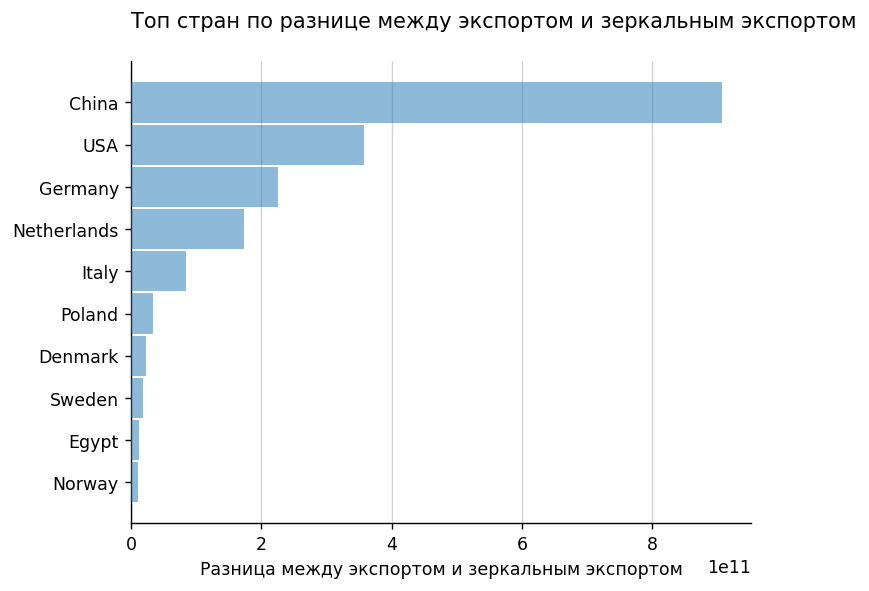

In [28]:
fig, ax = plt.subplots(dpi = 125)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Топ стран по разнице между экспортом и зеркальным экспортом\n',loc='left')
ax.barh(y = sort_zerkal.country,width = sort_zerkal.delta,height=0.95, zorder=1000, alpha=0.5)
# добавляем лейблы для осей
ax.set_xlabel('Разница между экспортом и зеркальным экспортом')
# добавляем сетку
ax.grid(color='lightgrey', axis='x', zorder=1)

# Почему так может происходить?

- Отсутствие данных по некоторым странам: Например, по России и Саудовской Аравии. Это отсутствие данных приводит к занижению экспорта, который мы рассчитываем зеркальным способом.

- Теневой сектор: Некоторые страны или компании могут намеренно завышать или занижать стоимость товаров для уменьшения налогов, что в свою очередь создаёт разницу между экспортом и зеркальным экспортом.